In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. 기본 설정 값 ---
g = 9.81
M_bottle = 0.05   
L = 0.12          
k = 1000.0        
c = 5.0           
I_bottle = (1/12) * M_bottle * (2*L)**2 

In [2]:
# --- 2. 미분방정식 (Sliding Mass Model) ---
def get_derivatives(t, state, m_water):
    x, vx, y, vy, theta, omega, r, vr = state
    ax = 0; ay = -g
    
    f_contact = 0
    if r > L: f_contact = -k * (r - L) - c * vr
    elif r < -L: f_contact = -k * (r - (-L)) - c * vr
        
    ar = r * omega**2 - g * np.cos(theta) + f_contact / m_water
    
    I_total = I_bottle + m_water * r**2
    torque_gravity = -m_water * g * r * np.sin(theta)
    coriolis_term = 2 * m_water * r * vr * omega
    alpha = (torque_gravity - coriolis_term) / I_total
    
    return np.array([vx, ax, vy, ay, omega, alpha, vr, ar])

In [3]:
# --- 3. RK4 Solver ---
def rk4_step(func, t, state, dt, m_water):
    k1 = func(t, state, m_water)
    k2 = func(t + 0.5*dt, state + 0.5*dt*k1, m_water)
    k3 = func(t + 0.5*dt, state + 0.5*dt*k2, m_water)
    k4 = func(t + dt, state + dt*k3, m_water)
    return state + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

In [4]:
# --- 4. 시뮬레이션 실행 ---
def run_simulation_full(fill_ratio, init_omega):
    m_max = 0.5
    m_water = m_max * fill_ratio
    if m_water < 0.01: m_water = 0.01

    state = np.array([0.0, 1.0, 1.0, 4.5, -np.pi/4, init_omega, -L+0.01, 0.0])
    t = 0; dt = 0.005; max_time = 2.0
    
    while t < max_time:
        state = rk4_step(get_derivatives, t, state, dt, m_water)
        t += dt
        y_bottom = state[2] - L * abs(np.cos(state[4]))
        if y_bottom <= 0: break
            
    final_theta = (state[4] + np.pi) % (2 * np.pi) - np.pi
    final_omega = abs(state[5])
    return abs(final_theta), final_omega

In [5]:
# --- 5. 데이터 수집 ---

# 1) 해상도 및 저장 공간 설정
fill_ratios = np.linspace(0.1, 0.9, 50)
omegas = np.linspace(5, 25, 50)

heatmap_data = np.zeros((len(omegas), len(fill_ratios))) # 각도 저장용
omega_map = np.zeros((len(omegas), len(fill_ratios)))    # 속도 저장용

# 2) 데이터 수집 루프 

for i, w in enumerate(omegas):
    for j, f in enumerate(fill_ratios):
        angle, omega_fin = run_simulation_full(f, w)
        
        # 시각화 오류 방지 (90도 이상은 90도로 고정)
        if angle > np.pi/2: angle = np.pi/2
        
        # 각도와 속도를 각각의 배열에 저장
        heatmap_data[i, j] = angle
        omega_map[i, j] = omega_fin


# 3) 무게 중심(CoM) 계산 함수  ---

def calculate_stability_score(f):
    
    y_bottle = 0.0 
    y_water = -L + (L * f)
    m_water = 0.5 * f

    if m_water < 0.01: m_water = 0.01
    y_cm_total = (M_bottle * y_bottle + m_water * y_water) / (M_bottle + m_water)
    h_cm_from_bottom = y_cm_total + L

    score = 1.0 - (h_cm_from_bottom / (2*L))
    return score ** 2

# 4) 최종 점수 계산 루프
final_scores = []
threshold_angle = 0.5    # 성공 기준: 각도
threshold_omega = 12.0   # 성공 기준: 속도

for j, f in enumerate(fill_ratios):
    count = 0
    for i in range(len(omegas)):
        angle = heatmap_data[i, j]
        omg = omega_map[i, j]
        
        # 각도 조건(AND) 속도 조건 모두 만족해야 성공
        if angle < threshold_angle and omg < threshold_omega:
            count += 1
            
    # 안정성 가중치 적용
    stability = calculate_stability_score(f)
    final_scores.append(count * stability)

final_scores = np.array(final_scores)

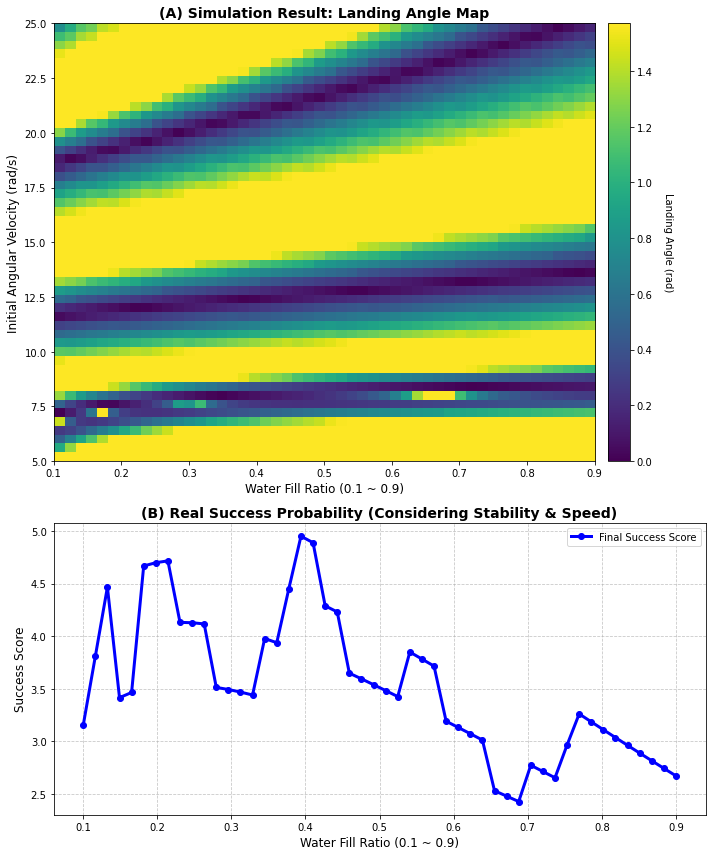

In [6]:
# --- 6. 시각화 (두 그래프 동시에 그리기) ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), gridspec_kw={'height_ratios': [1.5, 1]})

# [그래프 1] 2D Heatmap (Landing Angle)
# extent: [xmin, xmax, ymin, ymax]
im = ax1.imshow(heatmap_data, extent=[0.1, 0.9, 5, 25], origin='lower', 
           aspect='auto', cmap='viridis', vmin=0, vmax=np.pi/2)

ax1.set_title('(A) Simulation Result: Landing Angle Map', fontsize=14, fontweight='bold')
ax1.set_ylabel('Initial Angular Velocity (rad/s)', fontsize=12)
ax1.set_xlabel('Water Fill Ratio (0.1 ~ 0.9)', fontsize=12)

# 컬러바
cbar = fig.colorbar(im, ax=ax1, pad=0.02)
cbar.set_label('Landing Angle (rad)', rotation=270, labelpad=20)

# [그래프 2] 1D Line Graph (Final Probability)
ax2.plot(fill_ratios, final_scores, 'bo-', linewidth=3, label='Final Success Score')

ax2.set_title('(B) Real Success Probability (Considering Stability & Speed)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Water Fill Ratio (0.1 ~ 0.9)', fontsize=12)
ax2.set_ylabel('Success Score', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.7)

ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()